In [1]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from shapely.geometry import box
import pandas as pd
from matplotlib.patches import Patch


## Data loading

In [2]:
data_dir = Path('../data/')
shapefile_path = data_dir / 'data_1/HABNAT/HABNATs.shp'
one_tif_path = data_dir / 'data_3/zone95/230617_Ecomed_15cm_L93_4canaux_zone95_0_0.tif'
#one_tif_path = data_dir / 'data_2/zone48/230617_Ecomed_15cm_L93_4canaux_zone48_0_0.tif'

In [3]:
shapefile = gpd.read_file(shapefile_path)
# Add a unique id for each row 
shapefile['index'] = range(len(shapefile))
# Load the pivot table I generated to keep only polygons and images with more which intersect at more than 75%
intersect_df = pd.read_csv('../csv/intersection_shp_tif.csv')
filtered_shapefile = shapefile[shapefile['index'].isin(intersect_df['polygon_index'])]
filtered_tif_paths = intersect_df['tif_path'].unique()
#print('Before filtering, we had ', len(shapefile), ' polygons and ', len(my_tif_paths), ' tif images')
#print('After filtering, we have ', len(filtered_shapefile), ' polygons and ', len(filtered_tif_paths), ' tif images')

## Images

### Height

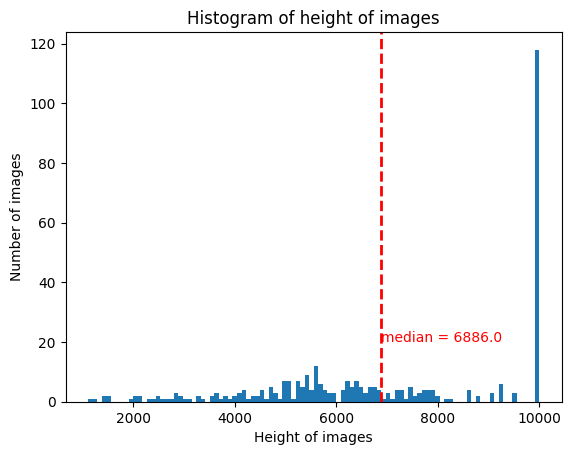

The number of images with height = 10000 represents  33 % of the total number of images.


In [36]:
# histograms of size of images
images_shape = []
for tif_path in filtered_tif_paths:
    with rasterio.open(tif_path) as src:
        resolution = src.res
        images_shape.append(src.shape)

images_shape = np.array(images_shape)
height_median = np.median(images_shape, axis=0)[0]
plt.hist(images_shape[:, 0], bins=100)
plt.axvline(height_median, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Height of images')
plt.ylabel('Number of images')
# add label for median
plt.text(height_median, 20, 'median = ' + str(height_median), rotation=0, color = 'red')
plt.title('Histogram of height of images')
plt.show()
print('The number of images with height = 10000 represents ', round(len(images_shape[images_shape[:, 0] == 10000]) * 100 / len(images_shape)), '% of the total number of images.')

## Polygons

### Areas: quartiles, median and mean

In [55]:
mean_area = round(filtered_shapefile['Shape_Area'].mean())
median_area = round(filtered_shapefile['Shape_Area'].median())
first_quantile_area = round(filtered_shapefile['Shape_Area'].quantile(0.25))
third_quantile_area = round(filtered_shapefile['Shape_Area'].quantile(0.75))
quin1_quantile_area = round(filtered_shapefile['Shape_Area'].quantile(0.05))
quin2_quantile_area = round(filtered_shapefile['Shape_Area'].quantile(0.95))
min_area = round(filtered_shapefile['Shape_Area'].min())
max_area = round(filtered_shapefile['Shape_Area'].max())

per_image = round(median_area * 100 / ((height_median * resolution[0])**2), 2) 

print(f"Minimum Area: {min_area}")
print(f"Maximum Area: {max_area}")
print('50% of the surfaces are between ' + str(min_area) + ' and ' + str(median_area) + ' m2, 50% are between ' + str(median_area) + ' and ' + str(max_area) + ' m2.')
print("With a resolution of", resolution[0], ", the median area", median_area, "m2 represents", per_image, "% of an image with the median dimensions.")
print('--------------------------------------------- Additional stats on area ---------------------------------------------')
print('25% of the surfaces are below ' + str(first_quantile_area) + ' m2.')
print('75% of the surfaces are above ' + str(third_quantile_area) + ' m2.')
print('05% of the surfaces are below ' + str(quin1_quantile_area) + ' m2.')
print('95% of the surfaces are below ' + str(quin2_quantile_area) + ' m2, it means that only 5% of the surfaces are between ' + str(quin2_quantile_area) + ' and ' + str(max_area) + ' m2.')
print(f"Mean Area: {mean_area} m2.")

Minimum Area: 0
Maximum Area: 386734
50% of the surfaces are between 0 and 1032 m2, 50% are between 1032 and 386734 m2.
With a resolution of 0.15 , the median area 1032 m2 represents 0.1 % of an image with the median dimensions.
--------------------------------------------- Additional stats on area ---------------------------------------------
25% of the surfaces are below 287 m2.
75% of the surfaces are above 3751 m2.
05% of the surfaces are below 25 m2.
95% of the surfaces are below 19733 m2, it means that only 5% of the surfaces are between 19733 and 386734 m2.
Mean Area: 4944 m2.


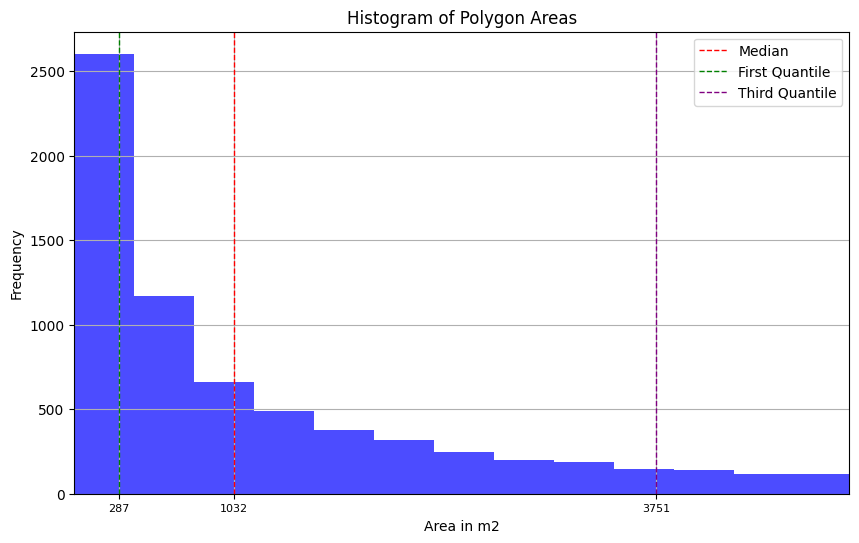

In [24]:
# For more visibility, let us truncate the x axis
plt.figure(figsize=(10, 6))
plt.xlim(min_area, 5000)
plt.hist(filtered_shapefile['Shape_Area'], bins=1000, color='blue', alpha=0.7)
plt.title('Histogram of Polygon Areas')
plt.xlabel('Area in m2')
plt.ylabel('Frequency')
plt.axvline(median_area, color='red', linestyle='dashed', linewidth=1, label='Median')
plt.axvline(first_quantile_area, color='green', linestyle='dashed', linewidth=1, label='First Quantile')
plt.axvline(third_quantile_area, color='purple', linestyle='dashed', linewidth=1, label='Third Quantile')
plt.legend()
plt.xticks([first_quantile_area, median_area, third_quantile_area], rotation=0, fontsize=8)
plt.grid(True)
plt.show()

### Areas

#### Fixing covery rate (taux de recouvrement) attribute: TXRECOUV_1

In [67]:
# TXRECOUV_1 attribute has the coverage percentage of the class 1 indicated in CDEUNIS_1
# count percentages of polygons with TX_RECOUV_1 == 0 
per_0 = round(len(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0]) * 100 / len(filtered_shapefile))
# count polygons with TXRECOUV_1 == 0
len_recouv_null = len(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0])
# count polyfons with TXRECOUV_1 == 0 and CDEUNIS_2 None
recouv_100_but_marked_as_0 = len(filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] == 0) & pd.isnull(filtered_shapefile['CDEUNIS_2'])])
mixed_lc_recouv_unknown = len_recouv_null - recouv_100_but_marked_as_0

In [71]:
print('The percentage of polygons with TXRECOUV_1 == 0 (covering rate at 0) is ', per_0, '%.')
print('It does not make sense to annotate polygons with a covery rate of 0%, thus we should make sense of this. ')
print('')
#print('Among the polygons with TXRECOUV_1 == 0(covering rate at 0), some of them are "pure" and others not. ')
print('Among the polygons with covering rate at 0, some of them have registered only one land cover (CDEUNIS_2 is None),  ')
print('In this case we think 0 should be 100. ')
print('It represents ', round(recouv_100_but_marked_as_0 * 100 / len_recouv_null), '% of the polygons with recovery rate at 0. ')
print('')
print('The other polygons with covering rate at 0 have several land covers (CDEUNIS_2 is not None)')
print('It represents ', round(mixed_lc_recouv_unknown * 100 / len_recouv_null), '% of the polygons with recovery rate at 0. ')
print('In this case, we think TXRECOUV_1 was set to 0 because it is unknown. ')

The percentage of polygons with TXRECOUV_1 == 0 (covering rate at 0) is  80 %.
It does not make sense to annotate polygons with a covery rate of 0%, thus we should make sense of this. 

Among the polygons with covering rate at 0, some of them have registered only one land cover (CDEUNIS_2 is None),  
In this case we think 0 should be 100. 
It represents  81 % of the polygons with recovery rate at 0. 

The other polygons with covering rate at 0 have several land covers (CDEUNIS_2 is not None)
It represents  19 % of the polygons with recovery rate at 0. 
In this case, we think TXRECOUV_1 was set to 0 because it is unknown. 


In [73]:
# Turn all recovery rates at 0 to 100 when CDEUNIS_2 is None in filtered_shapefile
filtered_shapefile.loc[(filtered_shapefile['TXRECOUV_1'] == 0) & pd.isnull(filtered_shapefile['CDEUNIS_2']), 'TXRECOUV_1'] = 100

#### Percentage of areas with single/multi-classes pixels

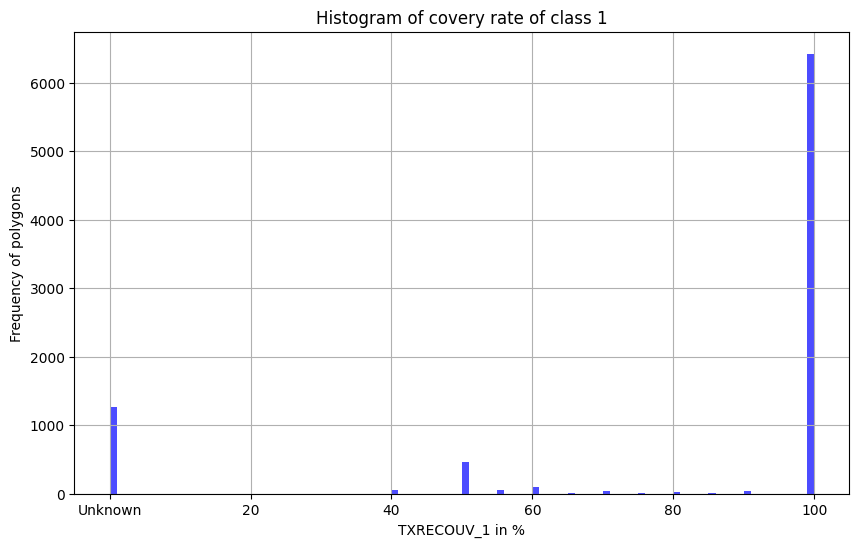

In [84]:
# histogram of TX_RECOUVR_1
plt.figure(figsize=(10, 6))
plt.hist(filtered_shapefile['TXRECOUV_1'], bins=100, color='blue', alpha=0.7)
plt.title('Histogram of covery rate of class 1')
plt.xlabel('TXRECOUV_1 in %')
plt.ylabel('Frequency of polygons')
# replace 0 by uknown
plt.xticks([0, 20, 40, 60, 80, 100], ['Unknown', '20', '40', '60', '80', '100'])
plt.grid(True)
plt.show()

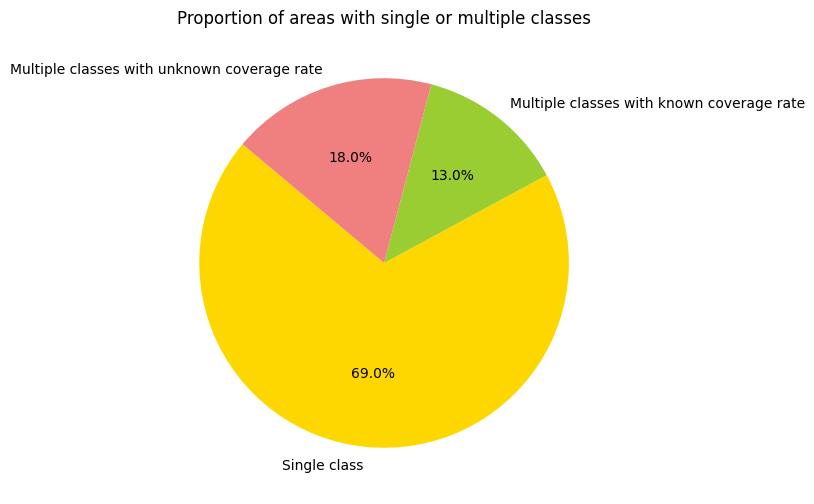

On the total surface covered by the polygons, 69% is labelled with a single class (TXRECOUV_1 = 100), 
31% is labelled with multiple classes (TXRECOUV_1 < 100). 
Among the surfaces assigned with multiple classes, 58% has uknown proportion of coverage (TXRECOUV_1 = 0). 
It represents 18% of all the areas. 


In [92]:
total_area = filtered_shapefile['Shape_Area'].sum()
per_area_single_class = round((filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 100]['Shape_Area'].sum() * 100 ) / total_area)

mixed_area = filtered_shapefile[filtered_shapefile['TXRECOUV_1'] < 100]['Shape_Area'].sum()
per_area_multiple_class = round(mixed_area * 100 / total_area)

unknown_cover = round(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0]['Shape_Area'].sum() * 100 / mixed_area)
unknown_cover_tot = round(filtered_shapefile[filtered_shapefile['TXRECOUV_1'] == 0]['Shape_Area'].sum() * 100 / total_area)

mixed_area_known = filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] < 100) & (filtered_shapefile['TXRECOUV_1'] > 0)]['Shape_Area'].sum()
per_area_multiple_class_known = round(mixed_area_known * 100  / total_area)

# pie plot with per_area_multiple_class_known, uknown cover and per_area_single_class
plt.figure(figsize=(10, 6))
labels=['Single class', 'Multiple classes with known coverage rate', 'Multiple classes with unknown coverage rate']
sizes=[per_area_single_class, per_area_multiple_class_known, unknown_cover_tot]
colors=['gold', 'yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of areas with single or multiple classes')
plt.show()

print('On the total surface covered by the polygons, ' + str(per_area_single_class) + '% is labelled with a single class (TXRECOUV_1 = 100), ')
print(str(per_area_multiple_class) + '% is labelled with multiple classes (TXRECOUV_1 < 100). ')
print('Among the surfaces assigned with multiple classes, ' + str(unknown_cover) + '% has uknown proportion of coverage (TXRECOUV_1 = 0). ') 
print('It represents ' + str(unknown_cover_tot) + '% of all the areas. ')

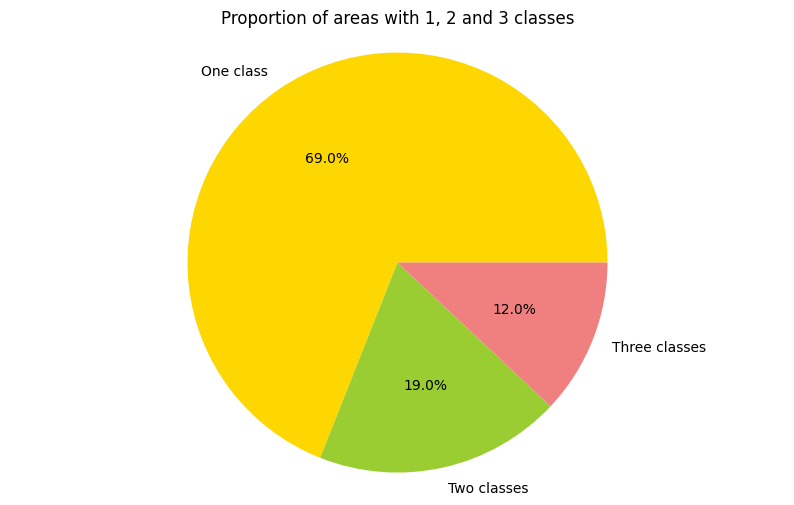

The proportion of area with exactly 2 classes is  19 %
The proportion of area with exactly 3 classes is  12 %


In [93]:
# Proportion of area with 2 classes CDEUNIS_1, CDEUNIS_2 not None and CDEUNIS_3 None
per_two_classes = round(filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] < 100) & pd.notnull(filtered_shapefile['CDEUNIS_2']) & pd.isnull(filtered_shapefile['CDEUNIS_3'])]['Shape_Area'].sum() * 100 / total_area)
# Proportion of area with 3 classes CDEUNIS_1, CDEUNIS_2 and CDEUNIS_3 not None
per_three_classes = round(filtered_shapefile[(filtered_shapefile['TXRECOUV_1'] < 100) & pd.notnull(filtered_shapefile['CDEUNIS_2']) & pd.notnull(filtered_shapefile['CDEUNIS_3'])]['Shape_Area'].sum() * 100 / total_area)

#make a pie plot. Percentage of 1 class, 2 classes, 3 classes
plt.figure(figsize=(10, 6))
labels = ['One class', 'Two classes', 'Three classes']
sizes = [per_area_single_class, per_two_classes, per_three_classes]
colors = ['gold', 'yellowgreen', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of areas with 1, 2 and 3 classes')
plt.show()

print('The proportion of area with exactly 2 classes is ', per_two_classes, '%')
print('The proportion of area with exactly 3 classes is ', per_three_classes, '%')

#### Does areas labelled with multiple classes have the same parent class (at the coarsest level of granularity) ?

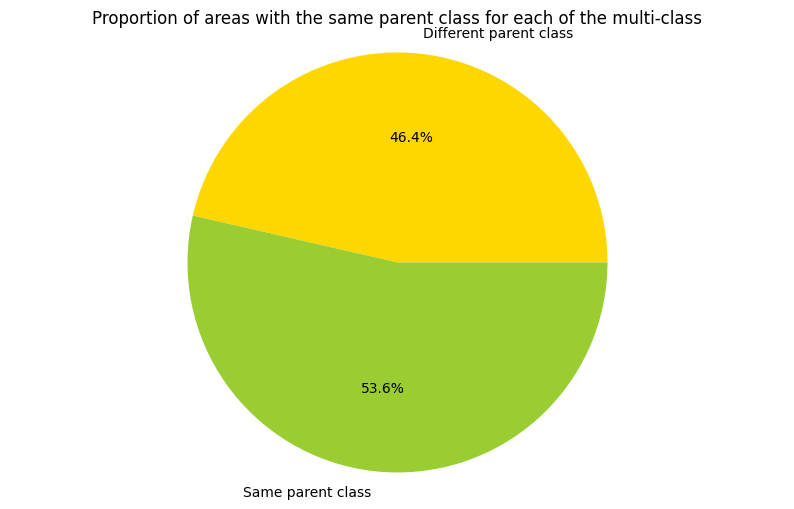

Among the multi-classes areas, the proportion of areas with the same parent class for each of the multi-class is  53.59 %


In [95]:
# select all areas with mixed classes
mixed_classes = filtered_shapefile[filtered_shapefile['TXRECOUV_1'] < 100]
# keep only CDEUNIS_1, CDEUNIS_2 and CDEUNIS_3
mixed_classes = mixed_classes[['CDEUNIS_1', 'CDEUNIS_2', 'CDEUNIS_3', 'Shape_Area']]
# keep only the first letter of each class for CDEUNIS_1 2 and 3 but not for shape_area
mixed_classes[['CDEUNIS_1', 'CDEUNIS_2', 'CDEUNIS_3']] = mixed_classes[['CDEUNIS_1', 'CDEUNIS_2', 'CDEUNIS_3']].applymap(lambda x: x[0] if isinstance(x, str) else x)
len_mixed_c = len(mixed_classes)
# sum area mixed classes
area_mixed_c = mixed_classes['Shape_Area'].sum()

# sum area of rows with CDEUNIS_1 == CDEUNIS_2 and CDEUNIS3 = None 
area_bimixed = mixed_classes[(mixed_classes['CDEUNIS_1'] == mixed_classes['CDEUNIS_2']) & pd.isnull(mixed_classes['CDEUNIS_3'])]['Shape_Area'].sum()

# sum area of rows with CDEUNIS_1 == CDEUNIS_2 == CDEUNIS_3
area_trimixed = mixed_classes[(mixed_classes['CDEUNIS_1'] == mixed_classes['CDEUNIS_2']) & (mixed_classes['CDEUNIS_1'] == mixed_classes['CDEUNIS_3'])]['Shape_Area'].sum()

area_l123_same = area_bimixed + area_trimixed 
per_l123_same = area_l123_same * 100 / area_mixed_c

# pie chart of the proportion of areas with the same parent class for each of the multi-class
plt.figure(figsize=(10, 6))
labels = ['Different parent class', 'Same parent class']
sizes = [100 - per_l123_same, per_l123_same]
colors = ['gold', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of areas with the same parent class for each of the multi-class')
plt.show()

print('Among the multi-classes areas, the proportion of areas with the same parent class for each of the multi-class is ', round(per_l123_same, 2), '%')

#### EUNIS classification level 1 and level 2

In [6]:
my_classes_l1 = {
    'A': 'Habitats marins', 
    'B': 'Habitats cotiers',
    'C': 'Eaux de surfaces continentales',
    'D': 'Tourbieres et bas-marais',
    'E': 'Prairies, terrains domines par des especes non graminoides, des mousses ou des lichens',
    'F': 'Landes, fourres et toundras',
    'G': 'Bois, forets et autres habitats boises',
    'H': 'Habitats continentaux sans vegetation ou à vegetation clairsemee',
    'I': 'Habitats agricoles, horticoles et domestiques régulierement ou recemment cultives',
    'J': 'Zones baties, sites industriels et autres habitats artificiels',
    'X': 'Complexes d habitats', 
    '1': "Erreur d'annotation ?",
}

colors_classes_l1 = {
    'A': '#1f77b4',  # Bleu
    'B': '#ffea00',  # Jaune
    'C': '#33a1c9',  # Bleu clair (différent de A)
    'D': '#8c564b',  # Marron
    'E': '#789262',  # Vert olive (différent de F)
    'F': '#ff4500',  # Rouge
    'G': '#006400',  # Vert foncé
    'H': '#90ee90',  # Vert clair
    'I': '#00ff00',  # Vert vif
    'J': '#555555',  # Vert gris (différent de E)
    'X': '#d3d3d3',  # Gris clair
    '1': '#8a2be2',  # Violet
}


In [11]:
my_classes_l2 = {
    'A1': 'roche et autres substrats durs intertidaux',
    'A2': 'sédiment intertidal',
    'A3': 'roche et autres substrats durs infralittoraux',
    'A4': 'roche et autres substrats durs circalittoraux',
    'A5': 'sédiment subtidal',
    'A6': 'habitats profonds',
    'A7': 'habitats pélagiques',
    'B1': 'dunes côtières et rivages sableux',
    'B2': 'galets côtiers',
    'B3': 'falaises, corniches et rivages rocheux, incluant le supralittoral',
    'C1': 'eaux dormantes de surface',
    'C2': 'eaux courantes de surface',
    'C3': 'zones littorales des eaux de surface continentales',
    'D1': 'tourbières hautes et tourbières de couverture',
    'D2': 'tourbières de vallée, bas-marais acides et tourbières de transition',
    'D4': 'bas-marais riches en bases et tourbières des sources calcaires',
    'D5': 'roselières sèches et cariçaies, normalement sans eau libre',
    'D6': 'marais continentaux salés et saumâtres et roselières',
    'E1': 'pelouses sèches',
    'E2': 'prairies mésiques',
    'E3': 'prairies humides et prairies humides saisonnières',
    'E4': 'pelouses alpines et subalpines',
    'E5': 'ourlets, clairières forestières et peuplements de grandes herbacées non graminées',
    'E6': 'steppes salées continentales',
    'E7': 'prairies peu boisées',
    'FB': 'plantations d arbustes',
    'F2': 'fourrés arctiques, alpins et subalpins',
    'F3': 'fourrés tempérés et méditerranéo-montagnards',
    'F4': 'landes arbustives tempérées',
    'F5': 'maquis, matorrals arborescents et fourrés thermo-méditerranéens',
    'F6': 'garrigues',
    'F7': 'landes épineuses méditerranéennes (phryganes, landes-hérisson et végétation apparentée des falaises littorales)',
    'F9': 'fourrés ripicoles et des bas-marais',
    'G1': 'forêts de feuillus caducifoliés',
    'G2': 'forêts de feuillus sempervirents',
    'G3': 'forêts de conifères',
    'G4': 'formations mixtes d’espèces caducifoliées et de conifères',
    'G5': 'alignements d’arbres, petits bois anthropiques, boisements récemment abattus, stades initiaux de boisements et taillis',
    'H1': 'grottes, systèmes de grottes, passages et plans d’eau souterrains terrestres',
    'H2': 'éboulis',
    'H3': 'falaises continentales, pavements rocheux et affleurements rocheux',
    'H4': 'habitats dominés par la neige ou la glace',
    'H5': 'habitats continentaux divers sans végétation ou à végétation clairsemée',
    'H6': 'reliefs volcaniques récents',
    'I1': 'cultures et jardins maraîchers',
    'I2': 'zones cultivées des jardins et des parcs',
    'J1': 'bâtiments des villes et des villages',
    'J2': 'constructions à faible densité',
    'J3': 'sites industriels d’extraction',
    'J4': 'réseaux de transport et autres zones de construction à surface dure',
    'J5': 'plans d’eau construits très artificiels et structures connexes',
    'J6': 'dépôts de déchets',
    'X': 'complexes d’habitats'
}

#### Percentages of areas by class at the first level of EUNIS classification

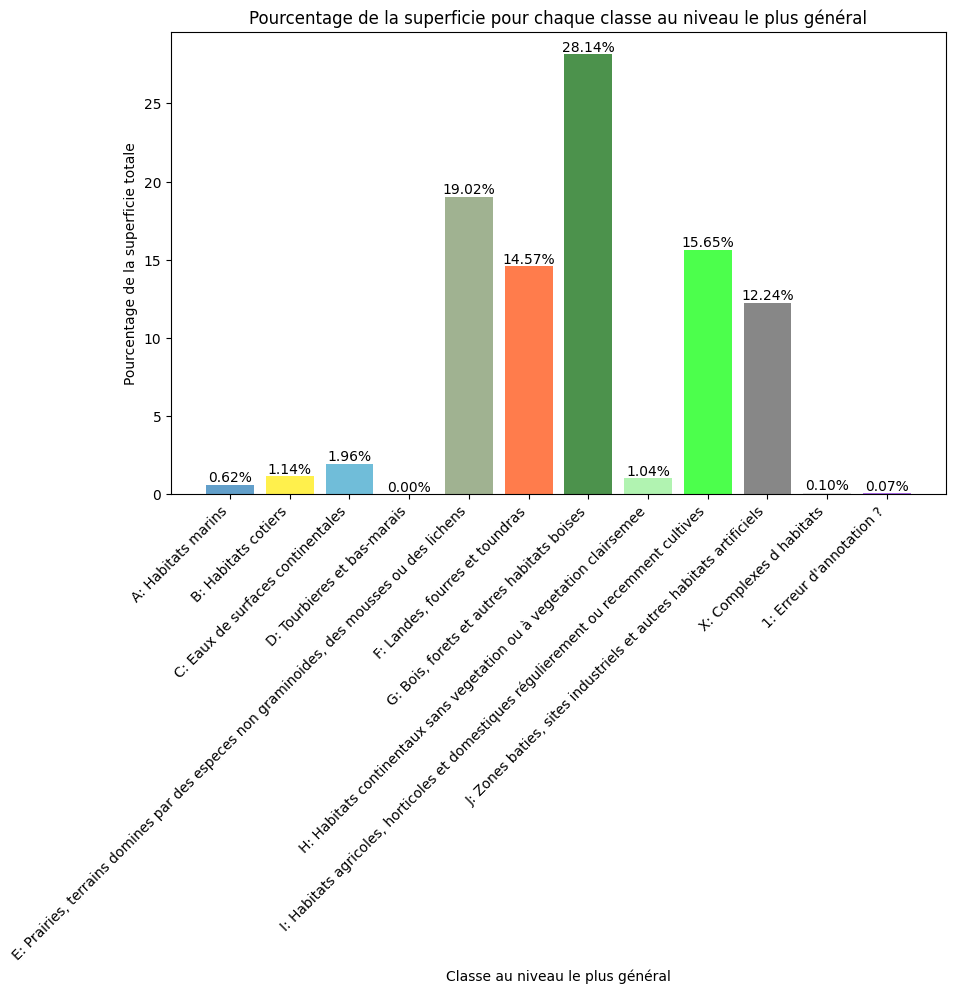

In [56]:
total_area = filtered_shapefile['Shape_Area'].sum()
filtered_shapefile = filtered_shapefile.copy()
# keep only the first letter of CDEUNIS_1
filtered_shapefile['CDEUNIS_1_l1'] = filtered_shapefile['CDEUNIS_1'].apply(lambda x: x[0] if isinstance(x, str) else x)
# make the some of shape_area attribute grouping by CDEUNIS_1
grouped = filtered_shapefile.groupby('CDEUNIS_1_l1')['Shape_Area'].sum()
# multiply by total_area and / 100 to get the percentage
grouped = grouped * 100 / total_area
grouped_sorted = grouped.loc[my_classes_l1.keys()]
plt.figure(figsize=(10, 6))
x_labels = [f'{key}: {value}' for key, value in my_classes_l1.items()]
bars = plt.bar(x_labels, grouped_sorted, color=[colors_classes_l1[key] for key in my_classes_l1.keys()], alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')

plt.title('Pourcentage de la superficie pour chaque classe au niveau le plus général')
plt.ylabel('Pourcentage de la superficie totale')
plt.xlabel('Classe au niveau le plus général')

plt.show()

#### Percentages of areas by class at the second level of EUNIS classification

In [30]:
# in filtered_shapefile, change G1131 by G1.131
filtered_shapefile.loc[filtered_shapefile['CDEUNIS_1'] == 'G1131', 'CDEUNIS_1'] = 'G1.131'

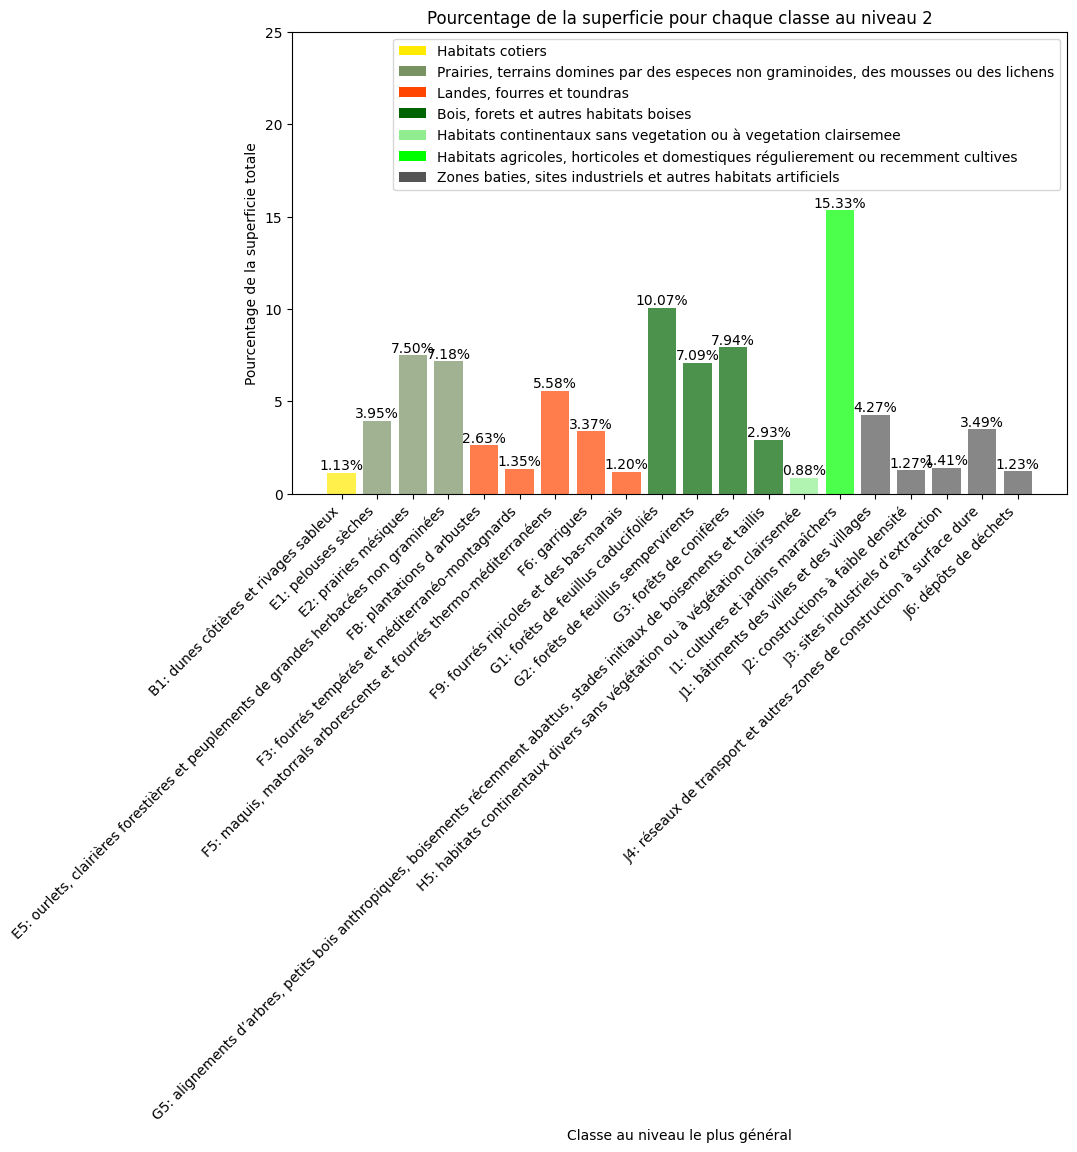

In [12]:
# keep only the first letter and first digit of CDEUNIS_1
filtered_shapefile = filtered_shapefile.copy()
filtered_shapefile['CDEUNIS_1_l2'] = filtered_shapefile['CDEUNIS_1'].apply(lambda x: x[0:2] if isinstance(x, str) else x)

total_area = filtered_shapefile['Shape_Area'].sum()
# make the some of shape_area attribute grouping by CDEUNIS_1_l2
area_by_group = filtered_shapefile.groupby('CDEUNIS_1_l2')['Shape_Area'].sum()
# multiply by 100 and / total_area to get the percentage
area_by_group = area_by_group * 100 / total_area
area_by_group = area_by_group.sort_values(ascending=False)
area_by_group_20 = area_by_group.head(20)
# Order the series by the order of my_classes_l2_20
my_classes_l2_20 = [key for key in my_classes_l2.keys() if key in area_by_group_20.index]
area_by_group_20 = area_by_group.loc[my_classes_l2_20] 
key_name_l2_classes = {code: my_classes_l2[code] for code in area_by_group_20.index}

# create a dict with the keys from my_classes_l2 and the values from the first letter of the key
my_classes_l2_l1 = {key: key[0] for key in my_classes_l2.keys() if key in area_by_group_20.index}
list_l1_classes = list(set(my_classes_l2_l1.values()))
# replace the value by the color value from the dict colors_dict
colors_dict_l2 = {key: colors_classes_l1[value] for key, value in my_classes_l2_l1.items()}

unique_labels = set()
legend_elements = []
for l, color in colors_dict_l2.items():
    label = my_classes_l1[my_classes_l2_l1[l]]
    if label not in unique_labels:
        legend_elements.append(Patch(facecolor=color, label=label))
        unique_labels.add(label)

plt.figure(figsize=(10, 6))
x_labels = [f'{key}: {value}' for key, value in key_name_l2_classes.items()]
bars = plt.bar(x_labels, area_by_group_20, color=[colors_dict_l2[key] for key in my_classes_l2_20], alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 25)
plt.title('Pourcentage de la superficie pour chaque classe au niveau 2')
plt.ylabel('Pourcentage de la superficie totale')
plt.xlabel('Classe au niveau le plus général')
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

#### Plot one image and a polygon

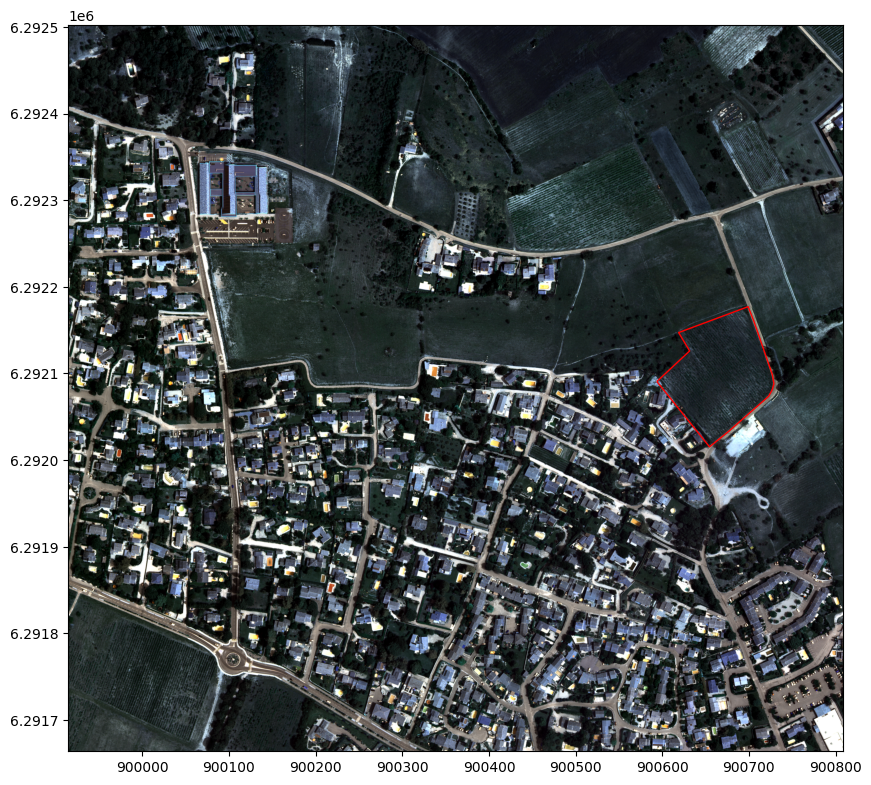

In [4]:
def rescale_band(band, p_min=2, p_max=98):
    p2, p98 = np.percentile(band, (p_min, p_max))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

def plot_image_with_polygon(min_surface_area, filtered_shapefile, intersect_df):
    # Load a shapefile polygon with area > min_surface_area
    filtered_polygon = filtered_shapefile[filtered_shapefile['Shape_Area'] > min_surface_area].iloc[0]

    # Get the path of the TIF image
    tif_path = intersect_df[intersect_df['polygon_index'] == filtered_polygon['index']]['tif_path'].values[0]

    # Open the TIF image
    with rasterio.open(tif_path) as src:
        # Read the image
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)

        # Rescale bands
        red_rescaled = rescale_band(red)
        green_rescaled = rescale_band(green)
        blue_rescaled = rescale_band(blue)

        # Stack bands to form RGB image
        rgb_image = np.dstack((red_rescaled, green_rescaled, blue_rescaled))

        # Get image bounds
        tif_bounds = src.bounds

        # Plot the image
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(rgb_image, extent=[tif_bounds.left, tif_bounds.right, tif_bounds.bottom, tif_bounds.top])

    # Plot the polygon on top
    polygon = filtered_polygon['geometry']
    gpd.GeoSeries([polygon]).plot(ax=ax, facecolor='none', edgecolor='red')

    plt.show()

# Example usage
plot_image_with_polygon(1000, filtered_shapefile, intersect_df)

### Number of polygons

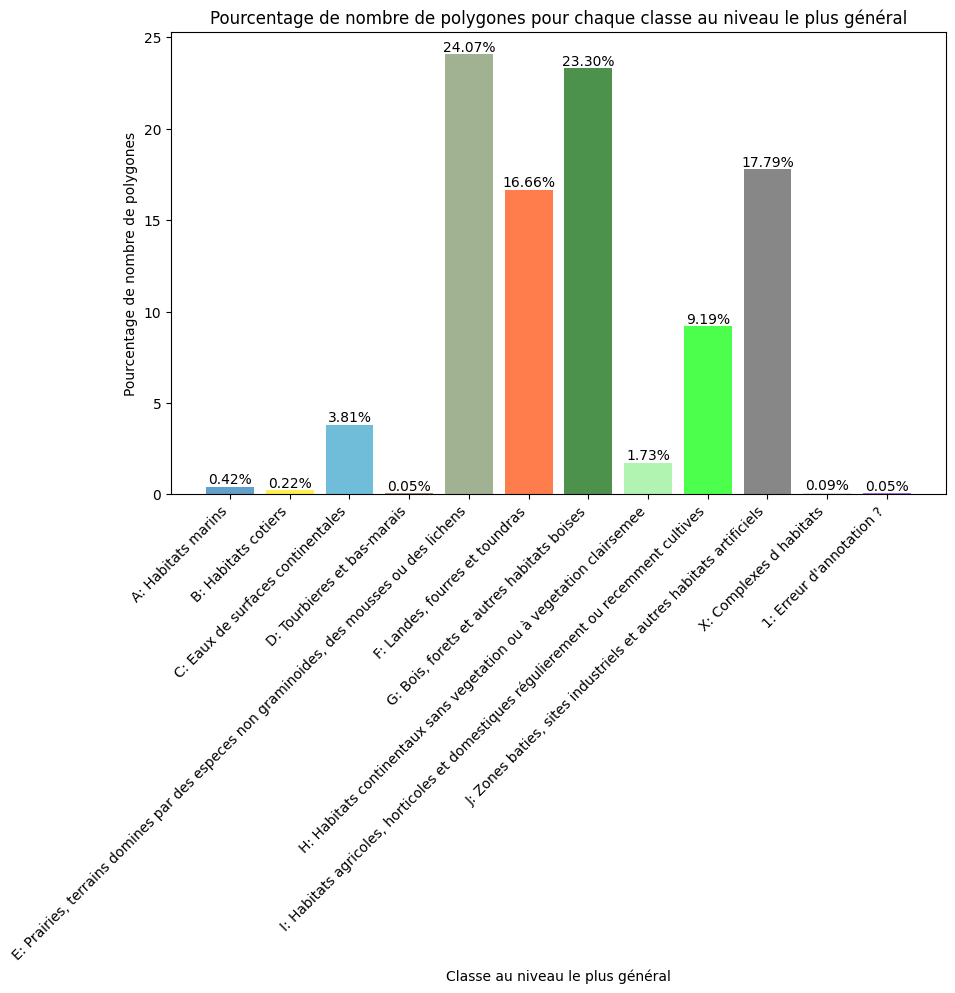

In [9]:
import matplotlib.pyplot as plt

# Calculate the total number of polygons
total_polygons = filtered_shapefile.shape[0]

# Copy the DataFrame to avoid modifying the original
filtered_shapefile = filtered_shapefile.copy()

# Keep only the first letter of CDEUNIS_1
filtered_shapefile['CDEUNIS_1_l1'] = filtered_shapefile['CDEUNIS_1'].apply(lambda x: x[0] if isinstance(x, str) else x)

# Group by CDEUNIS_1_l1 and count the number of polygons
grouped = filtered_shapefile.groupby('CDEUNIS_1_l1').size()

# Calculate the percentage of polygons for each class
grouped_percentage = grouped * 100 / total_polygons

# Sort the grouped_percentage Series based on the order defined by my_classes_l1
grouped_percentage_sorted = grouped_percentage.loc[my_classes_l1.keys()]

# Plot the bar chart
plt.figure(figsize=(10, 6))
x_labels = [f'{key}: {value}' for key, value in my_classes_l1.items()]
bars = plt.bar(x_labels, grouped_percentage_sorted, color=[colors_classes_l1[key] for key in my_classes_l1.keys()], alpha=0.7)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Pourcentage de nombre de polygones pour chaque classe au niveau le plus général')
plt.ylabel('Pourcentage de nombre de polygones')
plt.xlabel('Classe au niveau le plus général')

plt.show()

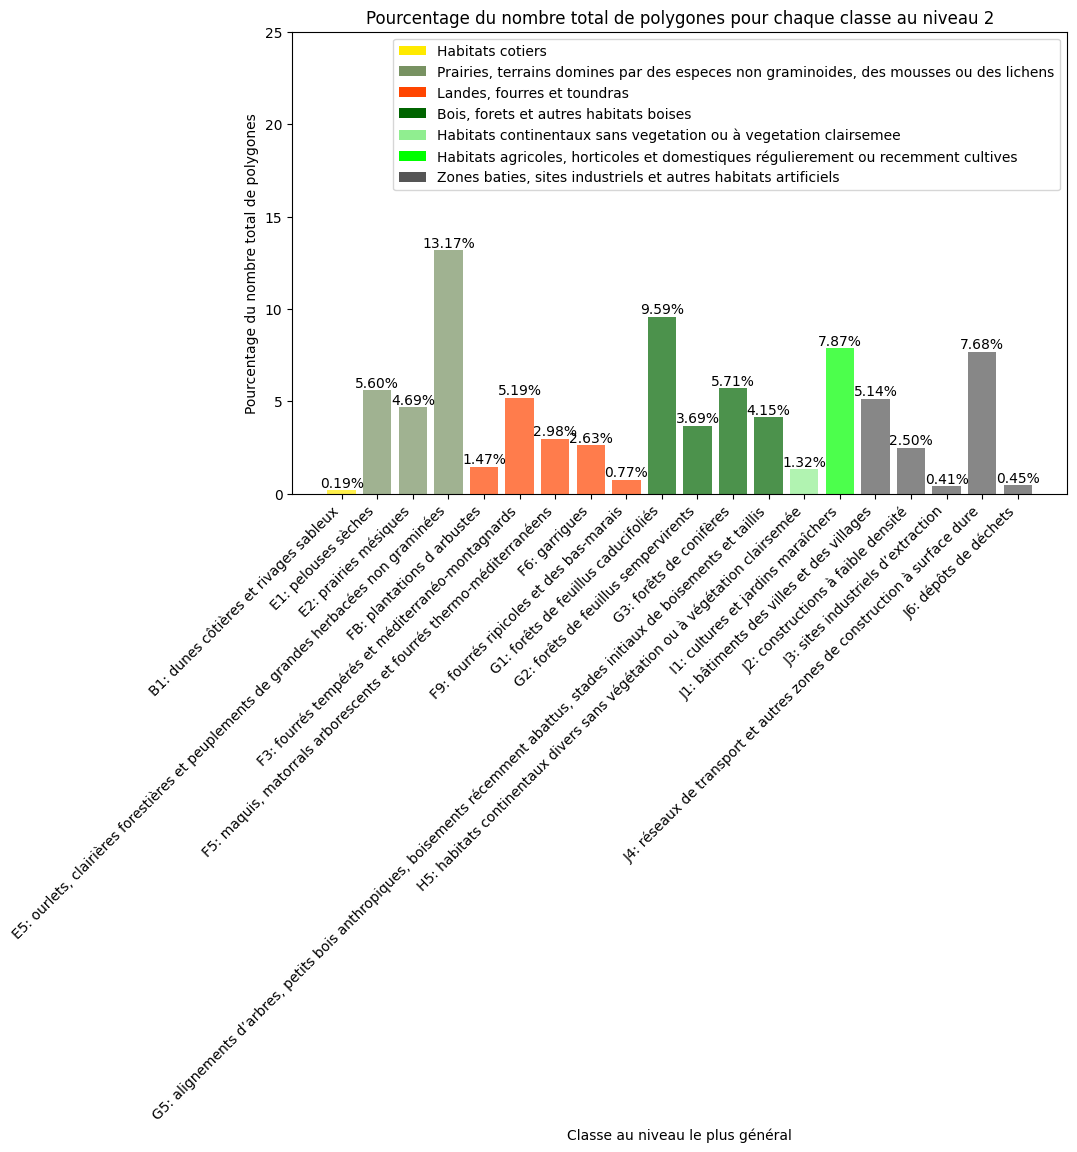

In [13]:
# Keep only the first letter and first digit of CDEUNIS_1
filtered_shapefile = filtered_shapefile.copy()
filtered_shapefile['CDEUNIS_1_l2'] = filtered_shapefile['CDEUNIS_1'].apply(lambda x: x[0:2] if isinstance(x, str) else x)

# Calculate the total number of polygons
total_polygons = filtered_shapefile.shape[0]

# Make the sum of shape_area attribute grouping by CDEUNIS_1_l2
polygon_count_by_group = filtered_shapefile.groupby('CDEUNIS_1_l2').size()

# Calculate the percentage of polygons for each class
polygon_percentage_by_group = polygon_count_by_group * 100 / total_polygons

# Sort the polygon_percentage_by_group Series based on the order defined by my_classes_l2_20
polygon_percentage_sorted = polygon_percentage_by_group.loc[my_classes_l2_20]

# Create a dictionary to map the keys from my_classes_l2 to their corresponding class names
key_name_l2_classes = {code: my_classes_l2[code] for code in polygon_percentage_sorted.index}

# Create a dictionary with the keys from my_classes_l2 and the values from the first letter of the key
my_classes_l2_l1 = {key: key[0] for key in polygon_percentage_sorted.index}
list_l1_classes = list(set(my_classes_l2_l1.values()))

# Replace the value by the color value from the dict colors_dict
colors_dict_l2 = {key: colors_classes_l1[value] for key, value in my_classes_l2_l1.items()}

# Create legend elements for the plot
unique_labels = set()
legend_elements = []
for l, color in colors_dict_l2.items():
    label = my_classes_l1[my_classes_l2_l1[l]]
    if label not in unique_labels:
        legend_elements.append(Patch(facecolor=color, label=label))
        unique_labels.add(label)

plt.figure(figsize=(10, 6))
x_labels = [f'{key}: {value}' for key, value in key_name_l2_classes.items()]
bars = plt.bar(x_labels, polygon_percentage_sorted, color=[colors_dict_l2[key] for key in my_classes_l2_20], alpha=0.7)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 25)
plt.title('Pourcentage du nombre total de polygones pour chaque classe au niveau 2')
plt.ylabel('Pourcentage du nombre total de polygones')
plt.xlabel('Classe au niveau le plus général')
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

### Date of polygons labelling (pb with ID_ETUDE)

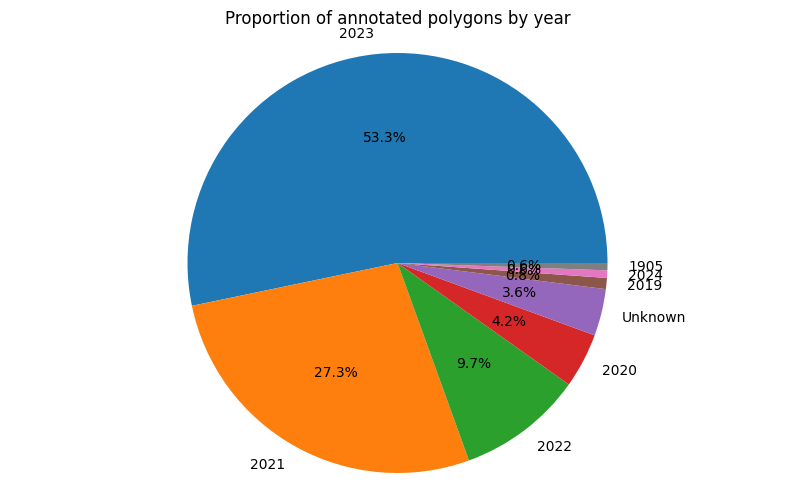

In [112]:
shapefile_zone_df = intersect_df.copy()
shapefile_zone_df['zone'] = shapefile_zone_df['tif_path'].apply(lambda x: x.split('/')[-2])
shapefile_zone_df = shapefile_zone_df[['polygon_index', 'zone']]

# add column zone to filtered_shapefile based on shared polygon_index
filtered_shapefile = pd.merge(filtered_shapefile, shapefile_zone_df, left_on='index', right_on='polygon_index', how='left')
filtered_shapefile.drop(columns=['polygon_index'], inplace=True)

dates_df = pd.read_excel(data_dir / 'data_1/HABNAT/BDD_AJ_HABNAT_FINALE2.xlsx')
dates_df = dates_df[['zone_AJ', 'date_habna']].drop_duplicates(subset='zone_AJ')
# add column date to filtered_shapefile based on shared zone_AJ
filtered_shapefile = pd.merge(filtered_shapefile, dates_df, left_on='zone', right_on='zone_AJ', how='left')
filtered_shapefile.drop(columns=['zone_AJ'], inplace=True)

dates_nan = filtered_shapefile['date_habna'].isnull().sum()
# select the 4 first digit of the string when it is not null

filtered_shapefile['year'] = filtered_shapefile['date_habna'].apply(lambda x: str(x)[:4] if not pd.isnull(x) else x)
# if possible convert the year to int
# turn year to 0 if it is null
filtered_shapefile['year'] = filtered_shapefile['year'].fillna(0)
filtered_shapefile['year'] = filtered_shapefile['year'].apply(lambda x: int(x))

# pie chart of polygons by year
plt.figure(figsize=(10, 6))
labels = filtered_shapefile['year'].value_counts().index
#change 0 label by uknonwn
labels = ['Unknown' if x == 0 else x for x in labels]
sizes = filtered_shapefile['year'].value_counts().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of annotated polygons by year')
plt.show()

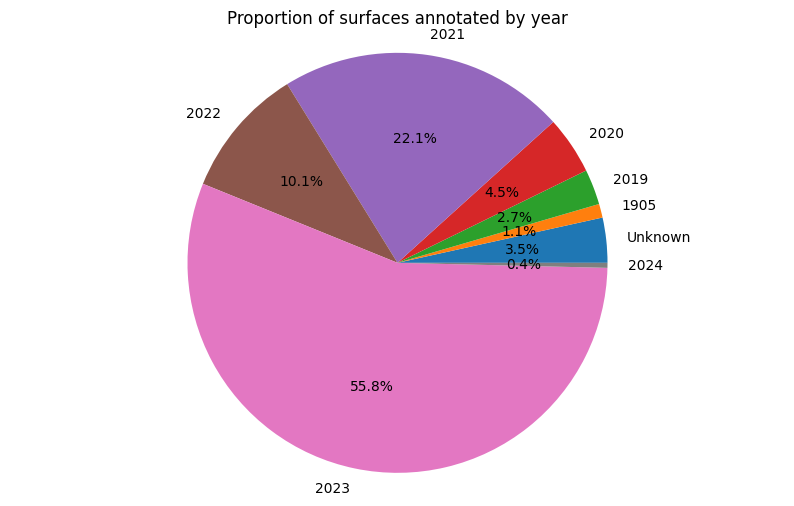

In [113]:
# pie plot of surfaces annotated by year
plt.figure(figsize=(10, 6))
labels = filtered_shapefile.groupby('year')['Shape_Area'].sum().index
labels = ['Unknown' if x == 0 else x for x in labels]
sizes = filtered_shapefile.groupby('year')['Shape_Area'].sum().values
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of annotated annotated by year')
plt.show()

### Impact of threshold tuning on intersection

In [8]:
my_tif_paths = list(data_dir.rglob('*.tif'))
my_polygons = shapefile[['index', 'geometry']]

intersect = []
# check or valid polygons
my_polygons = my_polygons[my_polygons['geometry'].is_valid]

def tune_threshold_inter(thresholds):
    # Process each TIFF file
    for threshold in thresholds:
        len_polygon_kept = 0
        for tif_path in my_tif_paths:
            with rasterio.open(tif_path) as src:
                tif_bounds = src.bounds
                tif_box = box(*tif_bounds)  # Convert BoundingBox to shapely box
                # Check each polygon
            for index, polygon in my_polygons.iterrows():
                geom = polygon['geometry']
                if geom is not None and tif_box.intersects(geom):
                    intersection = tif_box.intersection(geom)
                    intersection_percentage = intersection.area / geom.area

                    # Check if the intersection is greater than 75%
                    if intersection_percentage >= threshold:
                        #print(f'The polygon with index {polygon["index"]} intersects significantly with {tif_path.name}')
                        len_polygon_kept += 1
        print(f'For threshold {threshold}, {len_polygon_kept} polygons are kept, it represents {len_polygon_kept * 100 / len(my_polygons)}% of the total number of polygons. ')


In [116]:
my_thresholds_list = [0.5, 0.75, 0.90, 1]
tune_threshold_inter(my_thresholds_list)

For threshold 0.5, 9094 polygons are kept, it represents 78.94097222222223% of the total number of polygons. 
For threshold 0.75, 8611 polygons are kept, it represents 74.74826388888889% of the total number of polygons. 


KeyboardInterrupt: 

In [6]:
my_thresholds_list = [0.90]
tune_threshold_inter(my_thresholds_list)

For threshold 0.9, 8295 polygons are kept, it represents 72.00520833333333% of the total number of polygons. 


In [7]:
my_thresholds_list = [0.99]
tune_threshold_inter(my_thresholds_list)

For threshold 0.99, 8007 polygons are kept, it represents 69.50520833333333% of the total number of polygons. 


In [7]:
my_thresholds_list = [0.25, 0.01, 0, 1]
tune_threshold_inter(my_thresholds_list)

For threshold 0.25, 9653 polygons are kept, it represents 83.79340277777777% of the total number of polygons. 
For threshold 0.01, 10513 polygons are kept, it represents 91.25868055555556% of the total number of polygons. 
For threshold 0, 10633 polygons are kept, it represents 92.30034722222223% of the total number of polygons. 
For threshold 1, 2691 polygons are kept, it represents 23.359375% of the total number of polygons. 


In [9]:
my_thresholds_list = [0]
tune_threshold_inter(my_thresholds_list)

In [ ]:
my_thresholds_list = [1]
tune_threshold_inter(my_thresholds_list)

In [ ]:
threshold_dict = {
    0:, 
    0.01: 91, 
    0.25: 84, 
    0.5: 79, 
    0.75: 75, 
    0.9: 72,
    0.99: 70,
    1: 23,
}

### Pipeline to load polygons and images ####

In [2]:
data_dir = Path('../data/')
shapefile_path = data_dir / 'data_1/HABNAT/HABNATs.shp'
pivot_table_path = '../csv/intersection_shp_tif.csv'

# Read shapefile
shapefile = gpd.read_file(shapefile_path)
# Add unique index
shapefile['index'] = range(len(shapefile))
# Load pivot table
intersect_df = pd.read_csv(pivot_table_path)

# Filter shapefile and tif paths
filtered_shapefile = shapefile[shapefile['index'].isin(intersect_df['polygon_index'])]
filtered_tif_paths = intersect_df['tif_path'].unique()

# Correct TXRECOUV_1
filtered_shapefile.loc[(filtered_shapefile['TXRECOUV_1'] == 0) & pd.isnull(filtered_shapefile['CDEUNIS_2']), 'TXRECOUV_1'] = 100
filtered_shapefile.loc[filtered_shapefile['CDEUNIS_1'] == 'G1131', 'CDEUNIS_1'] = 'G1.131'

#### Plot all the polygons from one image (but images are quite heavy so kernel crashes)

986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0
986.0
2436.0
1050.0
3488.0
778.0
2414.0


KeyboardInterrupt: 

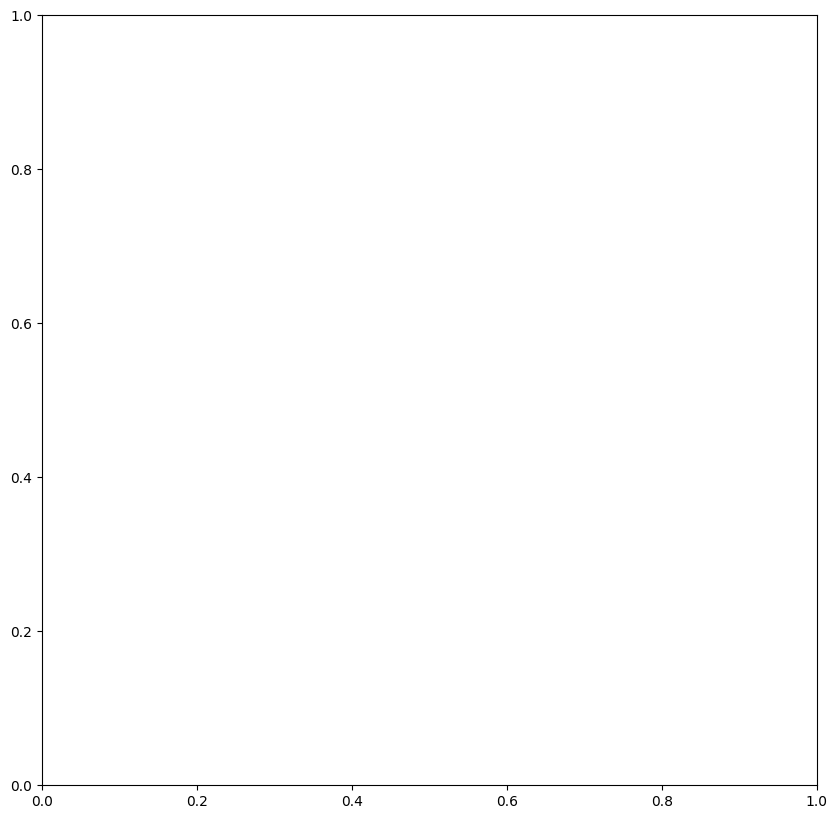

In [4]:
def rescale_band(band, p_min=2, p_max=98):
    p2, p98 = np.percentile(band, (p_min, p_max))
    return np.clip((band - p2) / (p98 - p2), 0, 1)

import logging
import traceback

# Set up logging
logging.basicConfig(level=logging.DEBUG, filename='debug.log', filemode='w', format='%(levelname)s - %(message)s')

def plot_image_with_polygons(min_surface_area, filtered_shapefile, intersect_df):
    try:
        # Filter polygons based on area
        filtered_polygons = filtered_shapefile[filtered_shapefile['Shape_Area'] > min_surface_area]

        # Get paths of TIF images corresponding to each polygon
        tif_paths = intersect_df[intersect_df['polygon_index'].isin(filtered_polygons['index'])]['tif_path'].values

        fig, ax = plt.subplots(figsize=(10, 10))

        for tif_path in tif_paths:
            # Open the TIF image
            with rasterio.open(tif_path) as src:
                # Read the image
                red = src.read(1)
                green = src.read(2)
                blue = src.read(3)

                # Rescale bands
                red_rescaled = rescale_band(red)
                green_rescaled = rescale_band(green)
                blue_rescaled = rescale_band(blue)

                # Stack bands to form RGB image
                rgb_image = np.dstack((red_rescaled, green_rescaled, blue_rescaled))

                # Get image bounds
                tif_bounds = src.bounds

                # Plot the image
                ax.imshow(rgb_image, extent=[tif_bounds.left, tif_bounds.right, tif_bounds.bottom, tif_bounds.top])

        # Plot polygons and label with class from CDEUNIS_1 column
        for index, polygon in filtered_polygons.iterrows():
            gpd.GeoSeries([polygon['geometry']]).plot(ax=ax, facecolor='none', edgecolor='red')
            # Get the class from CDEUNIS_1
            polygon_class = polygon['CDEUNIS_1']
            # Annotate the polygon with its class
            ax.annotate(polygon_class, (polygon['geometry'].centroid.x, polygon['geometry'].centroid.y),
                        color='black', fontsize=8, ha='center')

        plt.show()

    except Exception as e:
        logging.exception("Exception occurred")

# Example usage
plot_image_with_polygons(1000, filtered_shapefile, intersect_df)


In [ ]:
'''# make the code to plot one image, and all its polygons on top

tif_path = intersect_df['tif_path'].values[0]
# in intersect_df, select rows with intersect_df['tif_path'] = tif_path and keep the polygon
# polygons from filtered shapefile that intersect with the tif_path

def plot_image_with_polygons(filtered_shapefile, intersect_df, tif_path):

    # Open the TIF image
    with rasterio.open(tif_path) as src:
        # Read the image
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)

        # Rescale bands
        red_rescaled = rescale_band(red)
        green_rescaled = rescale_band(green)
        blue_rescaled = rescale_band(blue)

        # Stack bands to form RGB image
        rgb_image = np.dstack((red_rescaled, green_rescaled, blue_rescaled))

        # Get image bounds
        tif_bounds = src.bounds

        # Plot the image
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(rgb_image, extent=[tif_bounds.left, tif_bounds.right, tif_bounds.bottom, tif_bounds.top])

    # Plot the polygons associated to this image on top. The shared key is in intersect_df which have id_polygon and tif_path
    polygons = filtered_shapefile[filtered_shapefile['index'].isin(intersect_df[intersect_df['tif_path'] == tif_path]['polygon_index'])]'''
